In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [14]:
training_set_features = pd.read_csv("dataset/training_set_features.csv")
training_set_labels = pd.read_csv("dataset/training_set_labels.csv")
test_set_features = pd.read_csv("dataset/test_set_features.csv")
submission_format = pd.read_csv("dataset/submission_format.csv")

In [15]:
training_set_features.columns

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [16]:
training_set_labels.columns

Index(['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'], dtype='object')

In [17]:
test_set_features.columns

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [18]:
submission_format.columns

Index(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

In [19]:
# Merge features and labels for training set
data = training_set_features.merge(training_set_labels, on='respondent_id')

In [20]:
# Drop respondent_id and handle missing values
data = data.drop(columns=['respondent_id']).dropna()

In [21]:
# Define features and target variables
X = data.drop(columns=['xyz_vaccine', 'seasonal_vaccine'])
y_xyz = data['xyz_vaccine']
y_seasonal = data['seasonal_vaccine']

In [22]:
# Split the data into training and validation sets
X_train, X_val, y_xyz_train, y_xyz_val, y_seasonal_train, y_seasonal_val = train_test_split(
    X, y_xyz, y_seasonal, test_size=0.2, random_state=42
)

In [23]:
# Define preprocessing steps
categorical_features = ['age_group', 'education', 'race', 'sex', 'income_poverty',
                        'marital_status', 'rent_or_own', 'employment_status',
                        'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
numerical_features = list(set(X.columns) - set(categorical_features))

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

In [25]:
# Define the SVM model
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

In [34]:
# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    return roc_auc, fpr, tpr

In [35]:
# Evaluate SVM for xyz_vaccine
roc_auc_xyz, fpr_xyz, tpr_xyz = evaluate_model(svm_model, X_train, y_xyz_train, X_val, y_xyz_val)

In [36]:
# Evaluate SVM for seasonal_vaccine
roc_auc_seasonal, fpr_seasonal, tpr_seasonal = evaluate_model(svm_model, X_train, y_seasonal_train, X_val, y_seasonal_val)

In [37]:
# Print the results
print(f"SVM ROC AUC for xyz_vaccine: {roc_auc_xyz:.4f}")
print(f"SVM ROC AUC for seasonal_vaccine: {roc_auc_seasonal:.4f}")
print(f"SVM Mean ROC AUC: {(roc_auc_xyz + roc_auc_seasonal) / 2:.4f}")

SVM ROC AUC for xyz_vaccine: 0.8663
SVM ROC AUC for seasonal_vaccine: 0.8763
SVM Mean ROC AUC: 0.8713


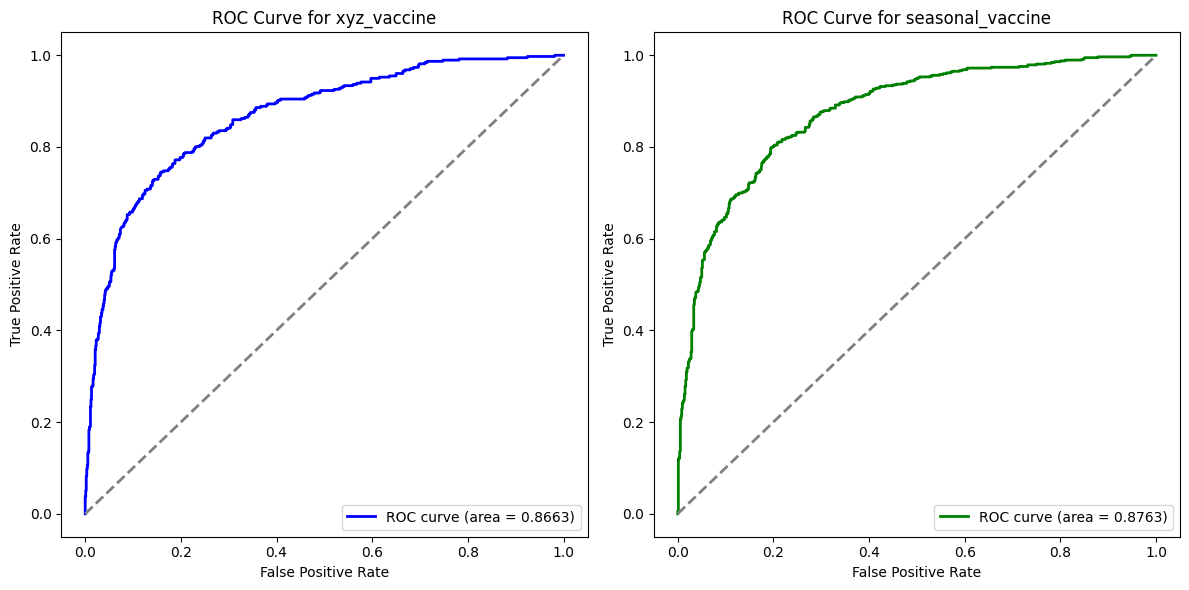

In [38]:
# Plot ROC curves
plt.figure(figsize=(12, 6))

# Plot ROC curve for xyz_vaccine
plt.subplot(1, 2, 1)
plt.plot(fpr_xyz, tpr_xyz, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_xyz:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for xyz_vaccine')
plt.legend(loc="lower right")

# Plot ROC curve for seasonal_vaccine
plt.subplot(1, 2, 2)
plt.plot(fpr_seasonal, tpr_seasonal, color='green', lw=2, label=f'ROC curve (area = {roc_auc_seasonal:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# For the final submission

In [30]:
respondent_ids = test_set_features['respondent_id']
test_features = test_set_features.drop(columns=['respondent_id'])

In [31]:
# Train on full training data for xyz_vaccine
svm_model.fit(X, y_xyz)
xyz_probabilities = svm_model.predict_proba(test_features)[:, 1]

# Train on full training data for seasonal_vaccine
svm_model.fit(X, y_seasonal)
seasonal_probabilities = svm_model.predict_proba(test_features)[:, 1]

ValueError: Found unknown categories [nan] in column 1 during transform

In [ ]:
# Prepare the submission file
submission = pd.DataFrame({
    'respondent_id': respondent_ids,
    'xyz_vaccine': xyz_probabilities,
    'seasonal_vaccine': seasonal_probabilities
})
submission.to_csv('submission_svm.csv', index=False)